<a href="https://colab.research.google.com/github/Pisarenkova/KT_2025/blob/main/%D0%9E%D0%B1%D1%89%D0%B0%D1%8F%D0%BA%D0%B0%D1%80%D1%82%D0%B8%D0%BD%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Библиотеки

Феникс

In [32]:
!apt-get install -y software-properties-common
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update
!apt-get install -y fenics

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Repository: 'deb https://ppa.launchpadcontent.net/fenics-packages/fenics/ubuntu/ jammy main'
Description:
This PPA provides packages for the FEniCS project (https://fenicsproject.org).
More info: https://launchpad.net/~fenics-packages/+archive/ubuntu/fenics
Adding repository.
Found existing deb entry in /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-jammy.list
Adding deb entry to /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-jammy.list
Found existing deb-src entry in /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-jammy.list
Adding key to /etc/apt/trusted.gpg.d/fenics-packages-ubuntu-fenics.gpg with fingerprint 6C1DA1C0EC4B649179C1C7437C3297B

In [33]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2025-03-28 14:28:31--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-03-28 14:28:31 (45.6 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1f33a7ab/releases/pybi

In [34]:
from fenics import *
#from petsc4py import PETSc

import numpy as np
#import matplotlib.pyplot as plt

# Точное решение
def u(x, y):
    return np.sin(k * x) * np.cos(l * y)

def create_mesh(h):
    #Прямоугольник
    p0 = Point(0.0, 0.0)
    p1 = Point(np.pi, np.pi)

    # Шаг h
    return RectangleMesh(p0, p1, int(np.pi/h), int(np.pi/h))

def solve_pde(f_exp, u_d, h):
    mesh = create_mesh(h)
    V = FunctionSpace(mesh, 'P', 1)

    # Граничные условия
    u_D = Expression(u_d, degree=2)
    bc = DirichletBC(V, u_D, 'on_boundary')

    # Вариационная форма
    u = TrialFunction(V)
    v = TestFunction(V)
    f_expr = Expression(f_exp, degree=2)
    #print(f_expr)
    a = inner(nabla_grad(u), nabla_grad(v)) * dx
    L = f_expr * v * dx

    # Решение
    u = Function(V)
    solve(a == L, u, bc)

    return mesh, u

PINN

In [6]:
import torch
import torch.nn as nn

#import numpy as np

from scipy.interpolate import griddata

# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA')
else:
    device = torch.device('cpu')
    print('CPU')

CUDA


In [7]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

In [8]:
class NN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        # initialize weight and Biases
        nn.init.xavier_uniform_(self.l1.weight)
        self.l1.bias.data.fill_(0.0)

        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l2.bias.data.fill_(0.0)
        nn.init.xavier_uniform_(self.l2.weight)

        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l3.bias.data.fill_(0.0)
        nn.init.xavier_uniform_(self.l3.weight)

        self.l4 = nn.Linear(hidden_size, output_size)
        nn.init.xavier_uniform_(self.l4.weight)
        self.l4.bias.data.fill_(0.0)

    def forward(self, x):
        out = self.l1(x)
        out = self.tanh(out)
        out = self.l2(out)
        out = self.tanh(out)
        out = self.l3(out)
        out = self.tanh(out)
        out = self.l4(out)
        return out

In [9]:
class PINN:
    # Initialize the class
    def __init__(self, layers, operator, bcs_sampler, res_sampler, k, l, kernel_size):

        # Normalization
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_t, self.sigma_t = self.mu_X[0], self.sigma_X[0]
        self.mu_x, self.sigma_x = self.mu_X[1], self.sigma_X[1]

        # Samplers
        self.operator = operator
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        # weights
        self.lam_u_val = torch.tensor(1.0).float().to(device)
        self.lam_r_val = torch.tensor(1.0).float().to(device)

        # Constant
        self.k = torch.tensor(k).float().to(device)
        self.l = torch.tensor(l).float().to(device)

        self.kernel_size = kernel_size # Size of the NTK matrix

        self.D1 = self.kernel_size    # boundary
        self.D2 = self.kernel_size    # ut
        self.D3 = self.kernel_size    # residual  D1 = D3 = 3D2

        # Neural Network
        self.nn = NN(layers[0], layers[1], layers[-1]).to(device)

        self.optimizer_Adam = torch.optim.Adam(params=self.nn.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
        self.my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=self.optimizer_Adam, gamma=0.9)

        # Logger
        self.loss_bcs_log = []
        self.loss_res_log = []

        # NTK logger
        self.K_u_log = []
        self.K_r_log = []

        # weights logger
        self.lam_u_log = []
        self.lam_r_log = []

    #    self.u_pred_log = []

    # Forward pass for u
    def net_u(self, t, x):

        if x.dim()==0:
            x = x.reshape(1)
            t = t.reshape(1)
            u = self.nn(torch.cat([t, x], dim=0))
        else:
            u = self.nn(torch.cat([t, x], dim=1))
        return u

    # Forward pass for the residual
    def net_r(self, t, x):
        u = self.net_u(t, x)
        residual = self.operator(u, t, x, self.k, self.l)
        return residual

    # Gradient operation
    def gradient(self, y, x, grad_outputs=None):
        if grad_outputs is None:
            grad_outputs = torch.ones_like(y)
        grad = torch.autograd.grad(y, [x], grad_outputs = grad_outputs, create_graph=True, allow_unused=True)[0]
        return grad

    # Compute Jacobian for each weights and biases in each layer and return a list
    def compute_jacobian(self, output, params):
        output = output.reshape(-1)
        J_dum = []
        J_List = []

        for i in range(len(params)):
            grad, = torch.autograd.grad(output, params[i], (torch.eye(output.shape[0]).to(device),),retain_graph=True, allow_unused=True, is_grads_batched=True)
            if grad == None:
                pass
            else:
                J_dum.append(grad)

                if np.mod(i,2)==1:
                    if grad == None:
                        pass
                    J_List.append(torch.cat((J_dum[i-1].flatten().reshape(len(output),-1),grad.flatten().reshape(len(output),-1)), 1))
        return J_List

    # Compute Neural Tangent Kernel's Trace Values
    def compute_ntk(self, J1, d1, J2, d2):

        Ker = torch.zeros((d1,d2)).float().to(device)

        for i in range(len(J1)):
            K = torch.matmul(J1[i], J2[i].t())
            Ker = Ker + K
        return Ker


    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        return X, Y

    # Trains the model by minimizing the MSE loss
    def train(self, nIter=10000, batch_size=128, log_NTK=False, update_lam=False):

        # NTK
        self.nn.train()

        saved_predictions = []

        for it in range(nIter):
            # Fetch boundary mini-batches
            X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size // 4)
            X_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size // 4)
            X_bc3_batch, u_bc3_batch = self.fetch_minibatch(self.bcs_sampler[2], batch_size // 4)
            X_bc4_batch, u_bc4_batch = self.fetch_minibatch(self.bcs_sampler[3], batch_size // 4)

            # Tensor

            X_bc1_batch_tens = torch.tensor(X_bc1_batch, requires_grad=True).float().to(device)
            u_bc1_batch_tens = torch.tensor(u_bc1_batch, requires_grad=True).float().to(device)

            X_bc2_batch_tens = torch.tensor(X_bc2_batch, requires_grad=True).float().to(device)
            u_bc2_batch_tens = torch.tensor(u_bc2_batch, requires_grad=True).float().to(device)

            X_bc3_batch_tens = torch.tensor(X_bc3_batch, requires_grad=True).float().to(device)
            u_bc3_batch_tens = torch.tensor(u_bc3_batch, requires_grad=True).float().to(device)

            X_bc4_batch_tens = torch.tensor(X_bc4_batch, requires_grad=True).float().to(device)
            u_bc4_batch_tens = torch.tensor(u_bc4_batch, requires_grad=True).float().to(device)

            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)
            X_res_batch_tens = torch.tensor(X_res_batch, requires_grad=True).float().to(device)

            u_pred_bc1 = self.net_u(X_bc1_batch_tens[:, 0:1], X_bc1_batch_tens[:, 1:2])
            u_pred_bc2 = self.net_u(X_bc2_batch_tens[:, 0:1], X_bc2_batch_tens[:, 1:2])
            u_pred_bc3 = self.net_u(X_bc3_batch_tens[:, 0:1], X_bc3_batch_tens[:, 1:2])
            u_pred_bc4 = self.net_u(X_bc4_batch_tens[:, 0:1], X_bc4_batch_tens[:, 1:2])

            r_pred = self.net_r(X_res_batch_tens[:, 0:1], X_res_batch_tens[:, 1:2])

            loss_bcs = torch.mean((u_pred_bc1-u_bc1_batch_tens) ** 2)+torch.mean((u_pred_bc2-u_bc2_batch_tens) ** 2)+torch.mean((u_pred_bc3-u_bc3_batch_tens) ** 2)+torch.mean((u_pred_bc4-u_bc4_batch_tens) ** 2)
            loss_res = torch.mean(r_pred ** 2)

            loss = self.lam_r_val * loss_res + self.lam_u_val * loss_bcs

            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()

            if it % 1000 == 0:
                self.my_lr_scheduler.step()

            # Print
            if it % 100 == 0:

                # Store losses
                self.loss_bcs_log.append(loss_bcs.detach().cpu().numpy())
                self.loss_res_log.append(loss_res.detach().cpu().numpy())

                print('It: %d, Loss: %.3e, Loss_res: %.3e,  Loss_bcs: %.3e' %
                      (it, loss.item(), loss_res, loss_bcs))

                print(f'lambda_u: {self.lam_u_val:3e}')
                print(f'lambda_r: {self.lam_r_val:3e}')



            if log_NTK:

                if it % 100 == 0:
                    print("Compute NTK...")
                    X_bc_batch = np.vstack([X_bc1_batch, X_bc2_batch, X_bc3_batch, X_bc4_batch])

                    # Convert to the tensor
                    X_bc_batch_tens = torch.tensor(X_bc_batch, requires_grad=True).float().to(device)

                    # Get the parameters of NN
                    params = list(self.nn.parameters())

                    # Store the trace
                    K_u_value = 0
                    K_r_value = 0

                    u_ntk_pred = self.net_u(X_bc_batch_tens[:,0:1], X_bc_batch_tens[:,1:2])
                    r_ntk_pred = self.net_r(X_res_batch_tens[:,0:1], X_res_batch_tens[:,1:2])

                    # Jacobian of the neural networks
                    J_u = self.compute_jacobian(u_ntk_pred, params)
                    J_r = self.compute_jacobian(r_ntk_pred, params)

                    # Neural tangent kernels of the neural networks / Trace values
                    K_u_value = self.compute_ntk(J_u, self.D1, J_u, self.D1)
                    K_r_value = self.compute_ntk(J_r, self.D3, J_r, self.D3)

                    # Convert tensor to numpy array
                    K_u_value = K_u_value.detach().cpu().numpy()
                    K_r_value = K_r_value.detach().cpu().numpy()

                    trace_K = np.trace(K_u_value) + np.trace(K_r_value)

                    # Store Trace values
                    self.K_u_log.append(K_u_value)
                    self.K_r_log.append(K_r_value)

                    if update_lam:

                        self.lam_u_val = trace_K / np.trace(K_u_value)
                        self.lam_r_val = trace_K / np.trace(K_r_value)

                        # Store NTK weights
                        self.lam_u_log.append(self.lam_u_val)
                        self.lam_r_log.append(self.lam_r_val)

    # Evaluates predictions at test points
    def predict_u(self, X_star):
        t = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        self.nn.eval()

        u_star = self.net_u(t, x)
        u_star = u_star.detach().cpu().numpy()
        return u_star



    # Evaluates predictions at test points
    def predict_r(self, X_star):

        t = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        self.nn.eval()

        r_star = self.net_r(t, x)
        r_star = r_star.detach().cpu().numpy()
        return r_star

In [10]:
# Define the exact solution and its derivatives
def u1(x, k, l):
    """
    :param x: x = (t, x)
    """
    t = x[:,0:1]
    x = x[:,1:2]
    return np.sin(k * t) * np.cos(l * x)

def f1(x,k,l):
    t = x[:,0:1]
    x = x[:,1:2]
    return (k**2 + l**2) * np.sin(k * t) * np.cos(l * x)

def u_tt(x, k, l):
    t = x[:,0:1]
    x = x[:,1:2]
    u_tt = -k**2 * np.sin(k * t) * np.cos(l * x)
    return u_tt

def u_xx(x, k, l):
    t = x[:,0:1]
    x = x[:,1:2]
    u_xx = -l**2 * np.sin(k * t) * np.cos(l * x)
    return  u_xx

def r(x, k, l):
    return -(u_tt(x, k, l) + u_xx(x, k, l))-f1(x, k, l)

def operator(u1, t, x, k, l):

    u_t = torch.autograd.grad(
        u1, t,
        grad_outputs=torch.ones_like(u1),
        retain_graph=True,
        create_graph=True
    )[0]

    u_tt = torch.autograd.grad(
        u_t, t,
        grad_outputs=torch.ones_like(u_t),
        retain_graph=True,
        create_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u1, x,
        grad_outputs=torch.ones_like(u1),
        retain_graph=True,
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    residual = -(u_tt + u_xx) - (k**2+l**2) * torch.sin(k * t)*torch.cos(l * x)
    return residual

In [11]:
# Domain boundaries

bc1_coords = np.array([[0.0, 0.0],
                        [np.pi, 0.0]])

bc2_coords = np.array([[0.0, np.pi],
                        [np.pi, np.pi]])

bc3_coords = np.array([[0.0, 0.0 ],
                        [0.0, np.pi]])

bc4_coords = np.array([[np.pi, 0.0],
                        [np.pi, np.pi]])

dom_coords = np.array([[0.0, 0.0],
                        [np.pi, np.pi]])

# Create initial conditions samplers
#ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u1(x, k, l), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u1(x, k, l), name='Dirichlet BC2')
bc3 = Sampler(2, bc3_coords, lambda x: u1(x, k, l), name='Dirichlet BC3')
bc4 = Sampler(2, bc4_coords, lambda x: u1(x, k, l), name='Dirichlet BC4')
bcs_sampler = [bc1, bc2, bc3, bc4]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, k, l), name='Forcing')

DEEPXDE

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.2 MB/s eta 0:00:00


In [2]:
import deepxde as dde

import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import tf

def domain():
    return dde.geometry.Rectangle(xmin=[0, 0], xmax=[np.pi, np.pi])

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    return -dy_xx - dy_yy - f(x)

def boundary(x, on_boundary):
    return on_boundary

def exact_solution(x):
    return np.sin(k * x[:, 0:1]) * np.cos(l*x[:, 1:2])

def f(x):
    return (k**2+l**2) * tf.sin(k * x[:, 0:1]) * tf.cos(l*x[:, 1:2])

def g(x):
    return exact_solution(x).reshape(-1, 1)

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



#Общая визуализация

In [55]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.gridspec as gridspec

u_d = ['sin(x[0])*cos(x[1])', 'sin(5*x[0])*cos(5*x[1])','sin(5*x[0])*cos(10*x[1])']
f_exp = ['sin(x[0])*cos(x[1])', '50*sin(5*x[0])*cos(5*x[1])','125*sin(5*x[0])*cos(10*x[1])']

def visualize_solution(model1,model,k,l,h,i):

    x1 = geom.uniform_points(2500, True)
    y_exact = g(x1)

    x = np.linspace(0, np.pi, 50)
    y = np.linspace(0, np.pi, 50)
    X, Y = np.meshgrid(x, y)
    y_exact1 = np.sin(k*X) * np.cos(l*Y)

    example=200
    t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], example)[:, None]
    x2 = np.linspace(dom_coords[0, 1], dom_coords[1, 1], example)[:, None]
    t, x2 = np.meshgrid(t, x2)
    X_star = np.hstack((t.flatten()[:, None], x2.flatten()[:, None]))

    u_star = u1(X_star, k,l)
    U_star = griddata(X_star, u_star.flatten(), (t, x2), method='cubic')

    u_pred = model1.predict_u(X_star)
    U_pred = griddata(X_star, u_pred.flatten(), (t, x2), method='cubic')

    mesh, u_solution = solve_pde(f_exp[i], u_d[i], h)
    #print(u_solution.vector())

    # Графики
    h_min, h_max, v_min, v_max = 0, np.pi, 0, np.pi

    fig = plt.figure(figsize=(15, 11))
    gs = gridspec.GridSpec(3, 5, height_ratios=[1,1,1], width_ratios=[1, 1, 0.04, 1, 0.04], wspace=0.5, hspace=0.3)

    #exact_sol = interpolate(Expression('sin(x[0])*cos(x[1])', degree=2), u_solution.function_space())

    titles = ["Точное решение", "Решение DeepXDE", "Абсолютное отклонение"]
    data = [y_exact1.reshape(50,50, order='F'), predictions[-1].reshape(50,50, order='F'), np.abs(y_exact - predictions[-1]).reshape(50,50, order='F')]

    def create_subplot(ax, data, title):
        c = ax.imshow(data, extent=(h_min, h_max, v_min, v_max), origin='lower', cmap='RdBu_r')
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_xticks([0, np.pi/2, np.pi])
        ax.set_xticklabels(['$0$', '$\pi/2$', '$\pi$'])
        ax.set_yticks([0, np.pi/2, np.pi])
        ax.set_yticklabels(['$0$', '$\pi/2$', '$\pi$'])
        if title == "Абсолютное отклонение":
          ax.set_xticks([])
          ax.set_yticks([])
        return c

   # c1 = create_subplot(fig.add_subplot(gs[0, 0]), data[0], titles[0])
    c2 = create_subplot(fig.add_subplot(gs[1, 0]), data[0], titles[0])

   # c3 = create_subplot(fig.add_subplot(gs[2, 0]), data[0], titles[0])

    c4 = create_subplot(fig.add_subplot(gs[1, 3]), data[2],titles[2])
    c5 = create_subplot(fig.add_subplot(gs[1, 1]), data[1],titles[1])

    def add_colorbar(c, ax, data):
      norm = plt.Normalize(np.min(data), np.max(data))
      cbar = fig.colorbar(c, cax=ax, norm=norm)
      cbar.set_ticks(np.linspace(np.min(data), np.max(data), 8).round(3))

    add_colorbar(c4, fig.add_subplot(gs[1, 4]), data[2])


    plot(u_solution,fig.add_subplot(gs[0,1]), extent=(h_min, h_max, v_min, v_max), origin='lower', cmap='RdBu_r')
    plt.title("Решение FEniCS", fontsize=12)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.xticks([0, np.pi/2, np.pi], ['$0$', '$\pi/2$', '$\pi$'])
    plt.yticks([0, np.pi/2, np.pi], ['$0$', '$\pi/2$', '$\pi$'])

    norm = colors.Normalize(vmin=-1, vmax=1)
    cbar = fig.colorbar(c2, cax=fig.add_subplot(gs[:, 2]), norm=norm, cmap='RdBu_r')
    cbar.set_ticks(np.linspace(np.min(data[0]), np.max(data[0]), 9).round(2))

    exact_sol = interpolate(Expression(u_d[i], degree=2), u_solution.function_space())
    plot(exact_sol, fig.add_subplot(gs[0,0]), cmap='RdBu_r', extent=(h_min, h_max, v_min, v_max), origin='lower')
    c=plot(abs(u_solution - exact_sol), fig.add_subplot(gs[0,3]), cmap='RdBu_r', extent=(h_min, h_max, v_min, v_max), origin='lower')
    plt.title("Абсолютная разность", fontsize=12)
    plt.xticks([])
    plt.yticks([])

    max=np.max(np.abs(u_solution.vector().get_local() - exact_sol.vector().get_local()))
    min=np.min(np.abs(u_solution.vector().get_local() - exact_sol.vector().get_local()))

    norm1 = plt.Normalize(min,max)
    cbar = fig.colorbar(c, cax=fig.add_subplot(gs[0, 4]), norm=norm1, cmap='RdBu_r')
    cbar.set_ticks(np.linspace(min,max, 9).round(4))

    titles1 = ["Точное решение", "Решение PINN", "Абсолютное отклонение"]
    data1 = [U_star.reshape(200,200, order='F'), U_pred.reshape(200,200, order='F'), np.abs(U_star-U_pred).reshape(200,200, order='F')]

    def create_subplot1(ax, data, title):
        c = ax.imshow(data, extent=(h_min, h_max, v_min, v_max), origin='lower', cmap='RdBu_r')
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_xticks([0, np.pi/2, np.pi])
        ax.set_xticklabels(['$0$', '$\pi/2$', '$\pi$'])
        ax.set_yticks([0, np.pi/2, np.pi])
        ax.set_yticklabels(['$0$', '$\pi/2$', '$\pi$'])
        if title == "Абсолютное отклонение":
          ax.set_xticks([])
          ax.set_yticks([])
        return c

    c7 = create_subplot1(fig.add_subplot(gs[2, 0]), data1[0],titles1[0])

    c8 = create_subplot1(fig.add_subplot(gs[2, 3]), data1[2],titles1[2])

    add_colorbar(c8, fig.add_subplot(gs[2, 4]), data1[2])

    c9 = create_subplot1(fig.add_subplot(gs[2, 1]), data1[1],titles1[1])

    plt.savefig('Общее сравнение для k=1, l=1.png')

    plt.show()


#Примеры

$k=1$, $\;l=1$

$u=\sin{x}⋅\cos{y}$


In [4]:
k = 1
l = 1

geom = domain()
bc = dde.icbc.DirichletBC(geom, g, boundary)
data = dde.data.PDE(geom, pde, bc, num_domain=2000, num_boundary=200, solution=g)

layer_size = [2] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

predictions = []

model.compile("adam", lr=0.001, metrics=["l2 relative error"])

for i in range(10):
    losshistory, train_state = model.train(iterations=1000)
    x1 = geom.uniform_points(2500, True)
    y_pred = model.predict(x1)
    predictions.append(y_pred)

#losshistory, train_state = model.train(iterations=6000)
#dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.134240 s

'compile' took 1.088463 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.01e+00, 2.54e-01]    [1.01e+00, 2.54e-01]    [1.00e+00]    
1000      [7.84e-04, 3.82e-04]    [7.84e-04, 3.82e-04]    [2.78e-02]    

Best model at step 1000:
  train loss: 1.17e-03
  test loss: 1.17e-03
  test metric: [2.78e-02]

'train' took 6.024207 s

Training model...

Step      Train loss              Test loss               Test metric   
1000      [7.84e-04, 3.82e-04]    [7.84e-04, 3.82e-04]    [2.78e-02]    
2000      [1.64e-04, 7.67e-05]    [1.64e-04, 7.67e-05]    [1.03e-02]    

Best model at step 2000:
  train loss: 2.41e-04
  test loss: 2.41e-04
  test metric: [1.03e-02]

'train' took 1.921637 s

Training model...

Step      Train loss              Test loss               Test metric   
2000      [1.64e-04, 7.67e-05]    [1.64e-04, 7.67e-05]    [1.03e-02]    
30

In [12]:
k = 1
l = 1

layers = [2, 500, 500, 500, 1]
kernel_size = 300
model1 = PINN(layers, operator, bcs_sampler, res_sampler, k, l, kernel_size)

In [13]:
# Train model
itertaions = 5001
log_NTK = False # Compute and store NTK matrix during training
update_lam = True # Compute and update the loss weights using the NTK

model1.train(nIter=itertaions, batch_size=kernel_size, log_NTK=log_NTK, update_lam=update_lam)

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


It: 0, Loss: 2.263e+00, Loss_res: 1.151e+00,  Loss_bcs: 1.112e+00
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 100, Loss: 9.464e-01, Loss_res: 5.993e-01,  Loss_bcs: 3.471e-01
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 200, Loss: 1.525e-01, Loss_res: 7.789e-02,  Loss_bcs: 7.457e-02
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 300, Loss: 6.835e-02, Loss_res: 2.428e-02,  Loss_bcs: 4.408e-02
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 400, Loss: 6.955e-03, Loss_res: 6.030e-03,  Loss_bcs: 9.250e-04
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 500, Loss: 4.827e-03, Loss_res: 4.148e-03,  Loss_bcs: 6.788e-04
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 600, Loss: 2.197e-02, Loss_res: 2.996e-03,  Loss_bcs: 1.898e-02
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 700, Loss: 4.637e-03, Loss_res: 3.939e-03,  Loss_bcs: 6.973e-04
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 800, Loss: 3.280e-03, Loss_res: 2.698e-03,  Loss_bcs: 5.824e-04
lambda_u: 1.000000e+00

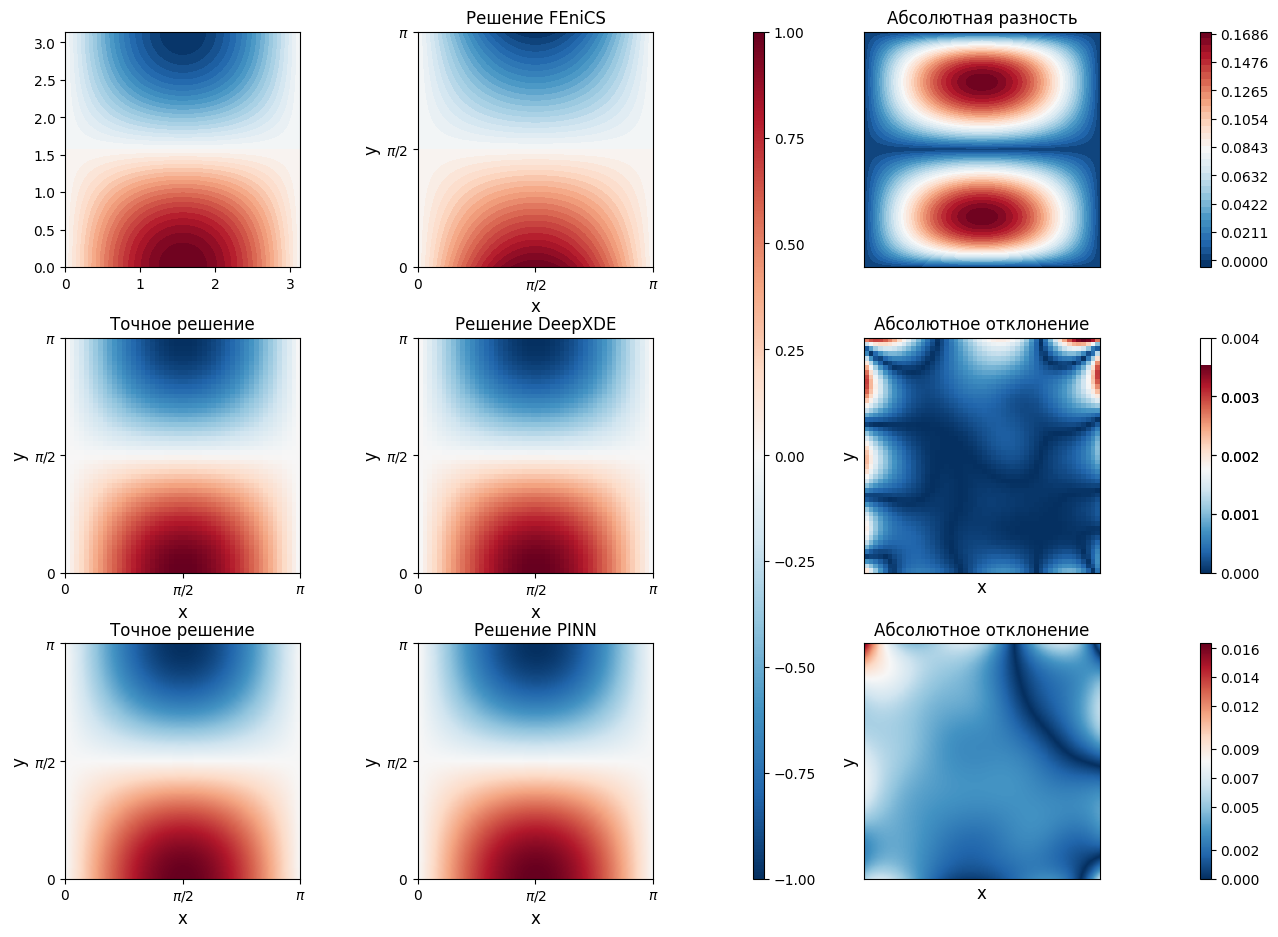

In [49]:
i = 0
h = 0.01

visualize_solution(model1,model,k,l,h,i)

$k=5$, $\;l=5$

$u=\sin{5x}⋅\cos{5y}$

In [50]:
k = 5
l = 5

geom = domain()
bc = dde.icbc.DirichletBC(geom, g, boundary)
data = dde.data.PDE(geom, pde, bc, num_domain=2000, num_boundary=200, solution=g)

layer_size = [2] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

predictions = []

model.compile("adam", lr=0.001, metrics=["l2 relative error"])

for i in range(10):
    losshistory, train_state = model.train(iterations=1000)
    x1 = geom.uniform_points(2500, True)
    y_pred = model.predict(x1)
    predictions.append(y_pred)

#losshistory, train_state = model.train(iterations=6000)
#dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.069148 s

'compile' took 0.659992 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [6.27e+02, 2.61e-01]    [6.27e+02, 2.61e-01]    [1.01e+00]    
1000      [1.24e+00, 2.94e-01]    [1.24e+00, 2.94e-01]    [6.33e-01]    

Best model at step 1000:
  train loss: 1.53e+00
  test loss: 1.53e+00
  test metric: [6.33e-01]

'train' took 4.691209 s

Training model...

Step      Train loss              Test loss               Test metric   
1000      [1.24e+00, 2.94e-01]    [1.24e+00, 2.94e-01]    [6.33e-01]    
2000      [2.58e-01, 6.09e-02]    [2.58e-01, 6.09e-02]    [2.68e-01]    

Best model at step 2000:
  train loss: 3.19e-01
  test loss: 3.19e-01
  test metric: [2.68e-01]

'train' took 2.426290 s

Training model...

Step      Train loss              Test loss               Test metric   
2000      [2.58e-01, 6.09e-02]    [2.58e-01, 6.09e-02]    [2.68e-01]    
30

In [51]:
k = 5
l = 5

layers = [2, 500, 500, 500, 1]
kernel_size = 300
model1 = PINN(layers, operator, bcs_sampler, res_sampler, k, l, kernel_size)

In [52]:
# Train model
itertaions = 10001
log_NTK = False # Compute and store NTK matrix during training
update_lam = True # Compute and update the loss weights using the NTK

model1.train(nIter=itertaions, batch_size=kernel_size, log_NTK=log_NTK, update_lam=update_lam)

It: 0, Loss: 6.018e+02, Loss_res: 6.008e+02,  Loss_bcs: 1.024e+00
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 100, Loss: 6.905e+02, Loss_res: 6.896e+02,  Loss_bcs: 9.213e-01
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 200, Loss: 6.117e+02, Loss_res: 6.108e+02,  Loss_bcs: 9.551e-01
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 300, Loss: 5.989e+02, Loss_res: 5.980e+02,  Loss_bcs: 9.883e-01
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 400, Loss: 5.194e+02, Loss_res: 5.183e+02,  Loss_bcs: 1.109e+00
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 500, Loss: 6.562e+02, Loss_res: 6.552e+02,  Loss_bcs: 9.632e-01
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 600, Loss: 6.006e+02, Loss_res: 5.995e+02,  Loss_bcs: 1.082e+00
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 700, Loss: 6.796e+02, Loss_res: 6.787e+02,  Loss_bcs: 8.807e-01
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 800, Loss: 5.684e+02, Loss_res: 5.673e+02,  Loss_bcs: 1.046e+00
lambda_u: 1.000000e+00

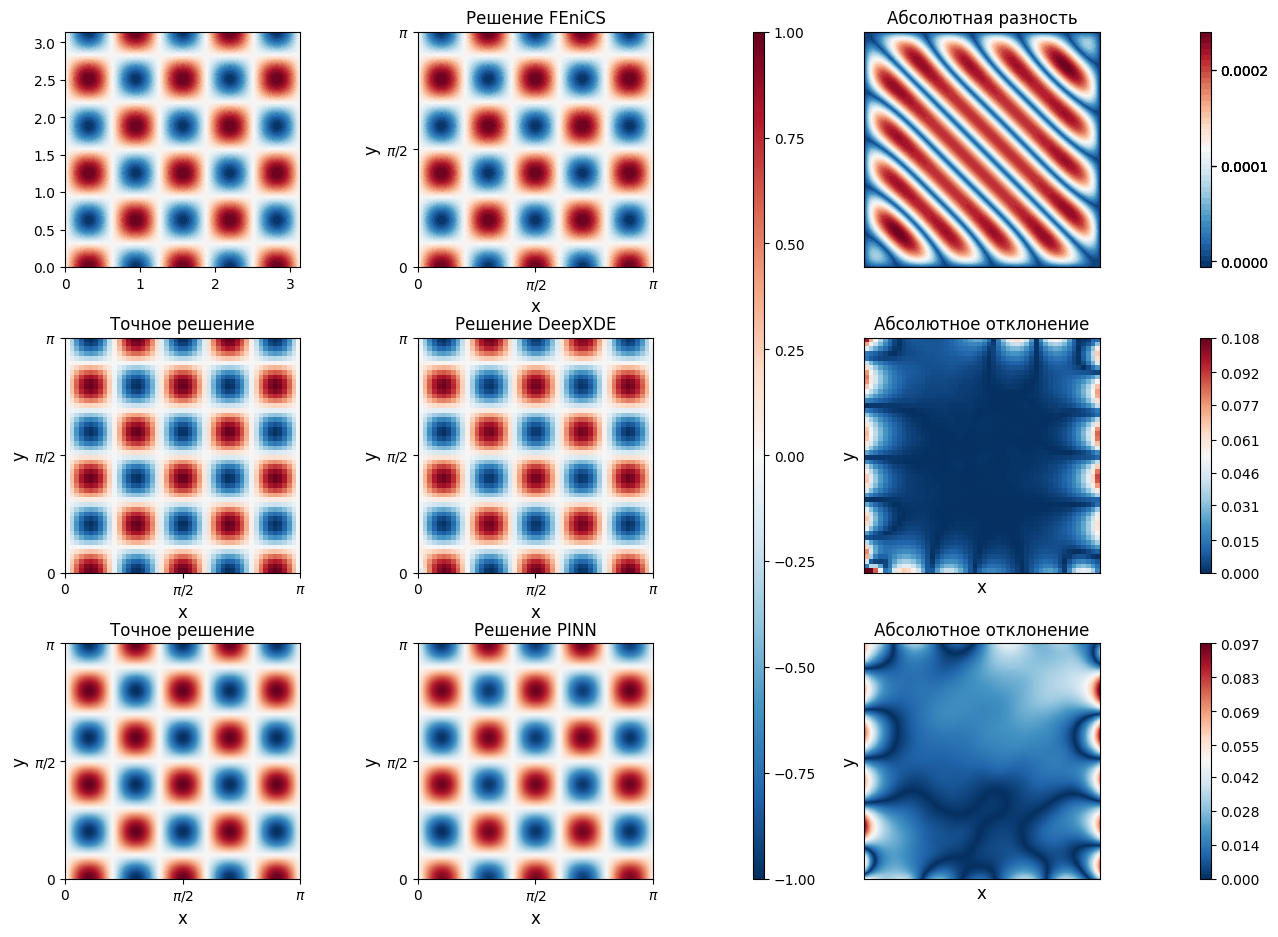

In [53]:
i = 1
h = 0.01

visualize_solution(model1,model,k,l,h,i)

$k=5$, $\;l=10$

$u=\sin{5x}⋅\cos{10y}$

In [54]:
k = 5
l = 10

geom = domain()
bc = dde.icbc.DirichletBC(geom, g, boundary)
data = dde.data.PDE(geom, pde, bc, num_domain=2000, num_boundary=200, solution=g)

layer_size = [2] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

predictions = []

model.compile("adam", lr=0.001, metrics=["l2 relative error"])

for i in range(15):
    losshistory, train_state = model.train(iterations=1000)
    x1 = geom.uniform_points(2500, True)
    y_pred = model.predict(x1)
    predictions.append(y_pred)

Compiling model...
Building feed-forward neural network...
'build' took 0.067666 s

'compile' took 0.628400 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [3.92e+03, 2.69e-01]    [3.92e+03, 2.69e-01]    [1.01e+00]    
1000      [1.09e+02, 2.81e+00]    [1.09e+02, 2.81e+00]    [2.09e+00]    

Best model at step 1000:
  train loss: 1.12e+02
  test loss: 1.12e+02
  test metric: [2.09e+00]

'train' took 4.810001 s

Training model...

Step      Train loss              Test loss               Test metric   
1000      [1.09e+02, 2.81e+00]    [1.09e+02, 2.81e+00]    [2.09e+00]    
2000      [4.02e+00, 7.63e-01]    [4.02e+00, 7.63e-01]    [1.03e+00]    

Best model at step 2000:
  train loss: 4.78e+00
  test loss: 4.78e+00
  test metric: [1.03e+00]

'train' took 2.159380 s

Training model...

Step      Train loss              Test loss               Test metric   
2000      [4.02e+00, 7.63e-01]    [4.02e+00, 7.63e-01]    [1.03e+00]    
30

In [56]:
k = 5
l = 10

layers = [2, 500, 500, 500, 1]
kernel_size = 300
model1 = PINN(layers, operator, bcs_sampler, res_sampler, k, l, kernel_size)

In [57]:
# Train model
itertaions = 30001
log_NTK = False # Compute and store NTK matrix during training
update_lam = True # Compute and update the loss weights using the NTK

model1.train(nIter=itertaions, batch_size=kernel_size, log_NTK=log_NTK, update_lam=update_lam)

It: 0, Loss: 3.636e+03, Loss_res: 3.635e+03,  Loss_bcs: 1.765e+00
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 100, Loss: 3.753e+03, Loss_res: 3.752e+03,  Loss_bcs: 1.027e+00
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 200, Loss: 3.804e+03, Loss_res: 3.803e+03,  Loss_bcs: 1.012e+00
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 300, Loss: 4.312e+03, Loss_res: 4.311e+03,  Loss_bcs: 9.501e-01
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 400, Loss: 4.241e+03, Loss_res: 4.240e+03,  Loss_bcs: 9.663e-01
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 500, Loss: 3.830e+03, Loss_res: 3.829e+03,  Loss_bcs: 1.038e+00
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 600, Loss: 3.854e+03, Loss_res: 3.853e+03,  Loss_bcs: 9.940e-01
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 700, Loss: 4.388e+03, Loss_res: 4.387e+03,  Loss_bcs: 1.011e+00
lambda_u: 1.000000e+00
lambda_r: 1.000000e+00
It: 800, Loss: 3.760e+03, Loss_res: 3.759e+03,  Loss_bcs: 8.541e-01
lambda_u: 1.000000e+00

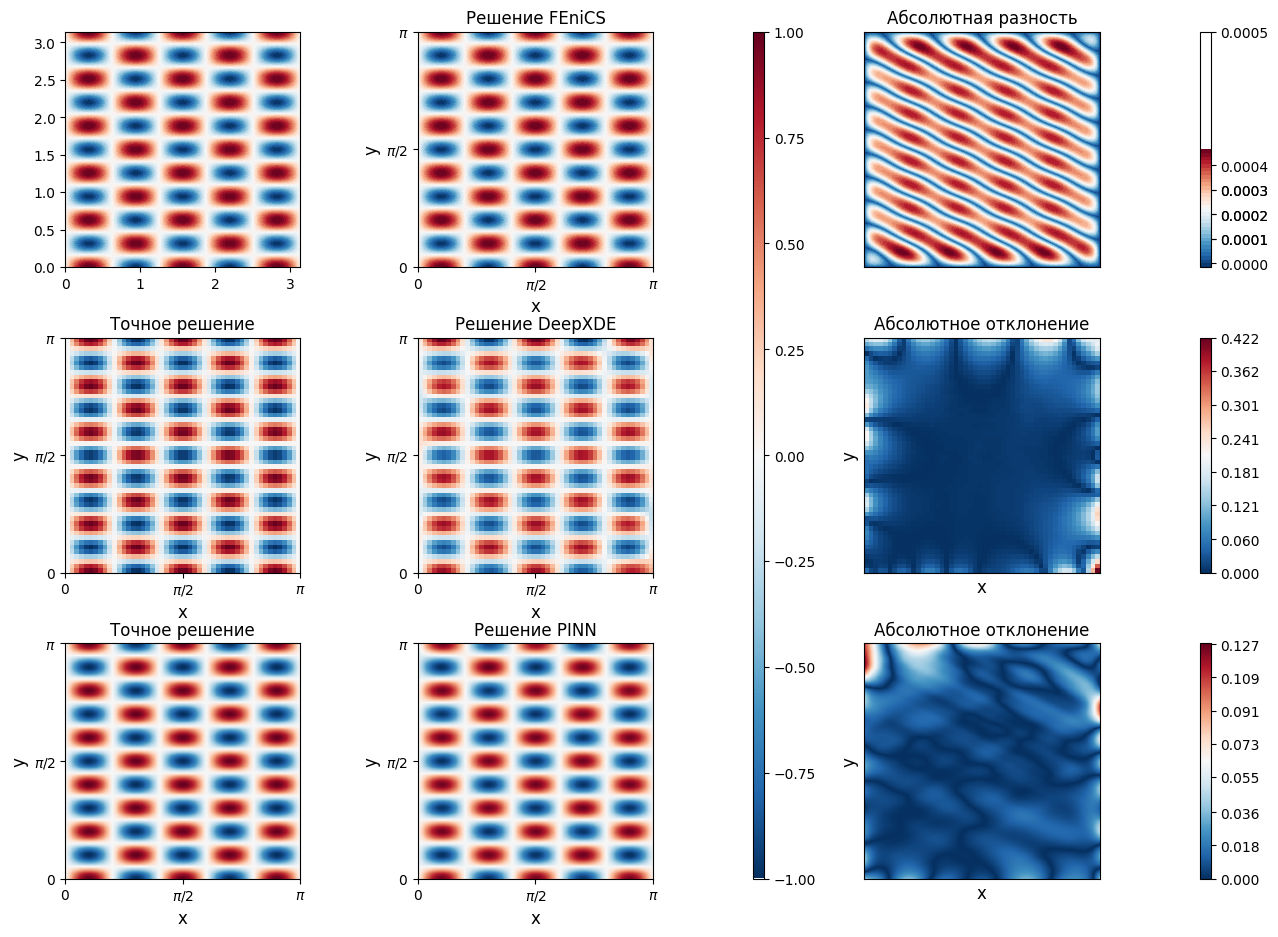

In [58]:
i = 2
h = 0.01

visualize_solution(model1,model,k,l,h,i)